In [21]:
import pandas as pd

wikipedia_movie_df = pd.read_csv('../data/wiki_movie_plots_deduped.csv', index_col=False, header=0)
wikipedia_movie_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [22]:
title_plot_df = wikipedia_movie_df[['Title','Plot']]
title_plot_df.head()

,Title,Plot
0,Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
1,Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
2,The Martyred Presidents,"The film, just over a minute long, is composed..."
3,"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
4,Jack and the Beanstalk,The earliest known adaptation of the classic f...


In [23]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s


In [24]:
title_plot_df.iloc[0,1]

"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]"

In [25]:
clean_text(title_plot_df.iloc[0,1])

'bartend work saloon serv drink custom fill stereotyp irish man bucket beer carri nation follow burst insid assault irish man pull hat ey dump beer head group begin wreck bar smash fixtur mirror break cash regist bartend sprai seltzer water nation face group policemen appear order everybodi leav'

In [26]:
title_plot_df['Plot'] = title_plot_df['Plot'].map(lambda x: clean_text(x))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in title_plot_df.iterrows():
    c = Counter(row['Plot'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

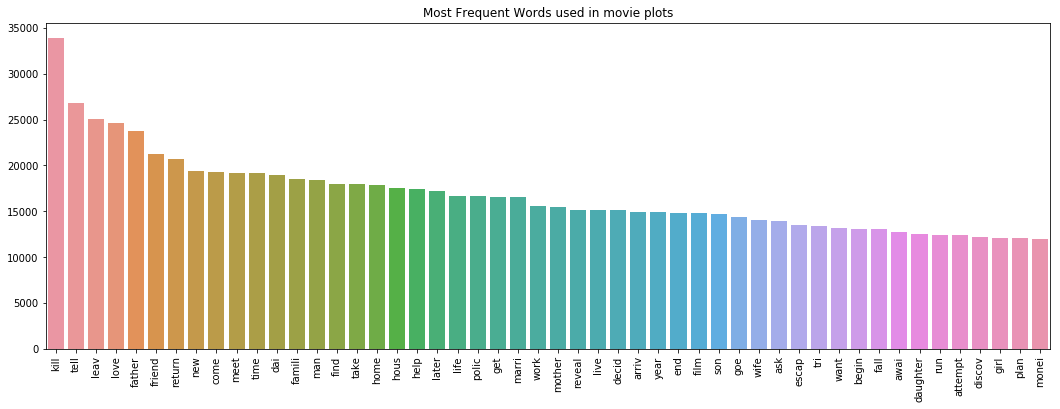

In [29]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in movie plots')

In [30]:
from itertools import islice

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)]    

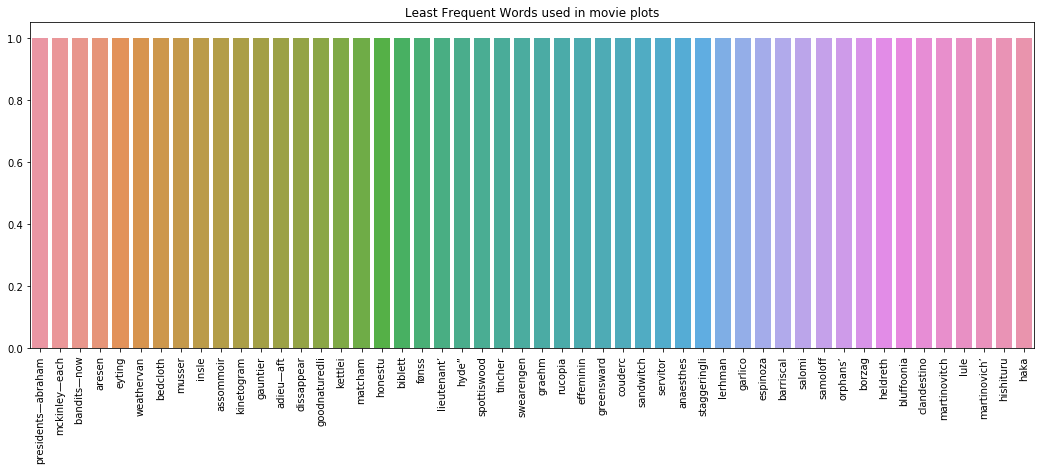

In [31]:
barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Least Frequent Words used in movie plots')

In [32]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['Plot']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['Plot']).split())
                                     for index, row in df_x.iterrows()]))
    


In [46]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(title_plot_df)
doc2vec_vectors = doc2vec_tr.transform(title_plot_df)

100%|██████████| 34886/34886 [00:00<00:00, 2265194.27it/s]


In [47]:
print(doc2vec_vectors)

[[ 9.1746646e-05  1.3870057e-03  1.6631397e-03 ...  9.0786419e-04
  -7.0541812e-04  1.3659769e-03]
 [ 6.0058269e-04 -6.9101038e-04  9.6981144e-05 ... -1.1877827e-03
   4.2445111e-04 -1.0841193e-03]
 [ 1.5052989e-03  1.4532509e-03 -1.3859750e-03 ...  1.4497949e-03
  -1.2424713e-03 -3.9357363e-04]
 ...
 [ 3.1223361e-04  3.0414126e-04  4.8154360e-04 ... -1.3821593e-03
   5.3430547e-04  1.6467636e-04]
 [ 2.4128749e-04 -7.8594725e-04 -1.4818109e-04 ... -2.3789924e-04
   1.2022003e-04 -9.6898328e-04]
 [ 5.3009891e-04 -1.0819612e-03 -1.6252364e-03 ... -1.1341607e-03
  -1.6588259e-04 -7.5160357e-04]]


In [48]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [49]:
print(predicted_vectors)

[[ 0.00071833  0.00229088 -0.00140108 ... -0.0021052   0.00032839
  -0.00084109]
 [ 0.00043641  0.00211585 -0.00194573 ... -0.00218298  0.00027503
  -0.00089203]
 [ 0.00045762  0.00235189 -0.00161442 ... -0.00264025  0.00017304
  -0.0011672 ]
 ...
 [ 0.00057708  0.00203284 -0.00188232 ... -0.00244237  0.00016045
  -0.00109326]
 [ 0.00055151  0.00177837 -0.00187524 ... -0.0024382   0.00048881
  -0.00069841]
 [ 0.00034545  0.00191106 -0.00185708 ... -0.00191412  0.00062527
  -0.00037884]]


In [50]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)

0.9524660796253925

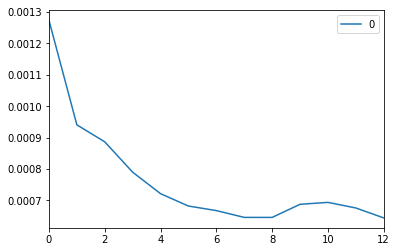

In [51]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [52]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(title_plot_df)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Movie Title: ', title_plot_df.iloc[index, 0])  
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [53]:
print('Top 5 unique movies')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Top 5 unique movies
Movie Title:  Ghar Basake Dekho
Cosine Sim Val : -0.26101806046944787
---------------------------------
Movie Title:  Trinetra
Cosine Sim Val : -0.2275712884394272
---------------------------------
Movie Title:  Tommy
Cosine Sim Val : -0.21002548464613824
---------------------------------
Movie Title:  Who Killed Gail Preston?
Cosine Sim Val : -0.2050815477530299
---------------------------------
Movie Title:  Ellaichami
Cosine Sim Val : -0.20507674714710666
---------------------------------


In [54]:
most_unique_movie_index, cosine_sim_val = sorted_cosine_similarities[0]
most_unique_movie_plot = title_plot_df.iloc[most_unique_movie_index, 1]
most_unique_movie_words_counter = Counter(preprocess_string(most_unique_movie_plot))

In [55]:
uncommon_word_count_items = [word for word in islice(all_word_counts, 300000)]
all_movies_uncommon_word_counter = Counter(dict(uncommon_word_count_items))
common_word_counter = Counter(aggregate_counter.most_common(1000))

In [56]:
intersected_uncommon_word_counter = all_movies_uncommon_word_counter & most_unique_movie_words_counter
intersected_uncommon_words = [word[0] for word in intersected_uncommon_word_counter.items()]
intersected_uncommon_word_counts = [word[1] for word in intersected_uncommon_word_counter.items()]

In [57]:
intersected_common_word_counter = common_word_counter & most_unique_movie_words_counter
intersected_common_words = [word[0] for word in intersected_common_word_counter.items()]
intersected_common_word_counts = [word[1] for word in intersected_common_word_counter.items()]
intersected_common_word_counter

Counter()

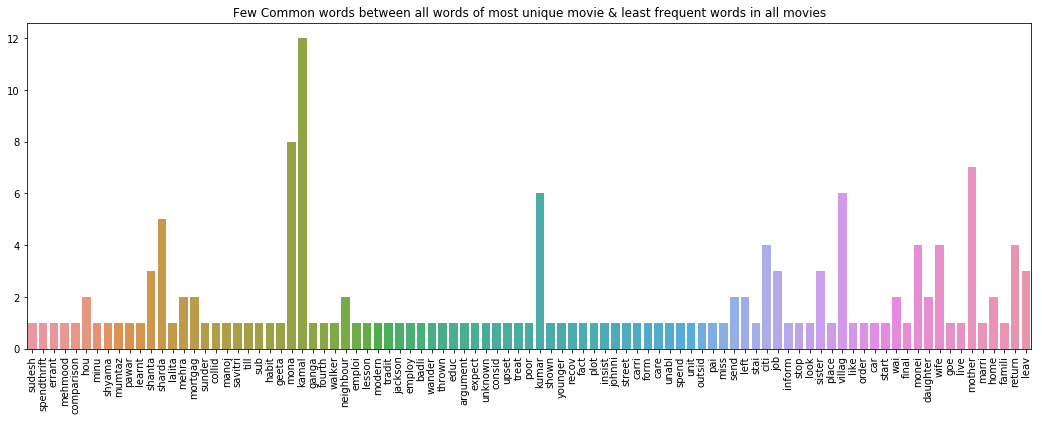

In [58]:
barplot(words=intersected_uncommon_words, words_counts=intersected_uncommon_word_counts,
        title='Few Common words between all words of most unique movie & least frequent words in all movies')